# DINOSim API example 🦖
Author: `Aitor Gonzalez-Marfil (@AAitorG)`

[DINOSim repo](https://github.com/AAitorG/napari-dinoSim)

## Setup
Import required libraries.

In [ ]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import torch

from napari_dinosim.utils import *

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


In [ ]:
#@title Data and Processing Parameters

#@markdown ### Data path
ds_path = '/content/drive/MyDrive/data' #@param {type:"string"}

#@markdown ### Processing crop shape (H,W,C)
crop_shape = (512,512,1) #@param {type:"raw"}

#@markdown ### Model input settings
#@markdown Should be multiple of model patch_size
resize_size = 518 #@param {type:"integer"}

# select model size
model_size = 'small' #@param {type:"string", options:["small", "base", "large", "giant"]}

## Load Data


In [ ]:
#find all files in given path
all_filenames = glob(os.path.join(ds_path, "*.*"))
all_filenames.sort()

#open all images
images = np.stack([load_image(filename) for filename in all_filenames])
if images.ndim == 3:
    # get images in format: (n,h,w,c)
    images = images[...,np.newaxis] # add channel dim

print(f'Number of images:  {len(images)} \t image shape: {images.shape[1:]}')

Number of images:  20 	 image shape: (1024, 512, 1)


# Load Model

In [ ]:
model_dims = {'small': 384, 'base': 768, 'large': 1024, 'giant': 1536}
assert model_size in model_dims, f'Invalid model size: ({model_size})'
model = torch.hub.load('facebookresearch/dinov2', f'dinov2_vit{model_size[0]}14_reg').to(device)
model.eval()

feat_dim = model_dims[model_size]

few_shot = DINOSim_pipeline(model, model.patch_size, device, get_img_processing_f(resize_size),
                             feat_dim, dino_image_size=resize_size )
print("Model loaded")

#Post-processing
kernel = gaussian_kernel(size=3, sigma=1)
kernel = torch.tensor(kernel, dtype=torch.float32, device=device)
filter_f = lambda x: torch_convolve(x, kernel)

# Prompting

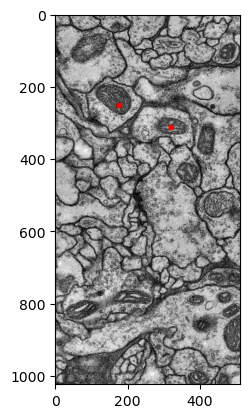

In [ ]:
# select reference points
points = [(0, 175, 250), (0,320, 310)]
z, x, y = zip(*points)

plt.imshow(images[z[0]], 'gray')
plt.scatter(x, y, c='r', marker='.')
plt.show()

# DINOSim

In [ ]:
# few_shot.delete_precomputed_embeddings()
# few_shot.delete_references()
if not few_shot.emb_precomputed:
    few_shot.pre_compute_embeddings(images, overlap = (0,0), padding=(0,0), crop_shape=crop_shape, verbose=True, batch_size=5)
few_shot.set_reference_vector(list_coords=points)
distances = few_shot.get_ds_distances_sameRef(verbose=False)
predictions = few_shot.distance_post_processing(distances, filter_f, upsampling_mode="bilinear")
print("Finished")

Precomputing embeddings
Embeddings stored on CPU


100%|██████████| 8/8 [00:23<00:00,  2.90s/it]


Finished


# Plot results

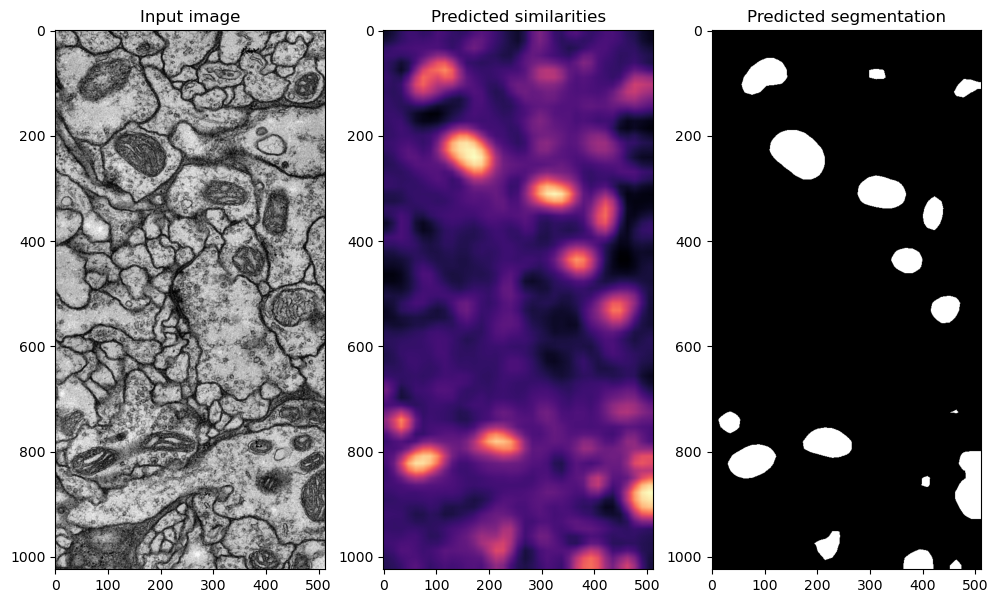

In [ ]:
# select threshold
threshold = .5

for i in range(1):
    input_img = images[i]
    plt.figure(figsize=(12,7))
    plt.subplot(131)
    if input_img.shape[-1] == 1:
        plt.imshow(input_img[...,0], 'gray')
    else:
        plt.imshow(input_img)
    plt.title("Input image")
    plt.subplot(132)
    plt.imshow(1-predictions[i], 'magma')
    plt.title("Predicted similarities")
    plt.subplot(133)
    plt.imshow(predictions[i] < threshold, 'gray')
    plt.title("Predicted segmentation")
    plt.show()

## (optional) SAM2 post-processing

In [ ]:
from napari_dinosim.utils import SAM2Processor
sam2_processor = SAM2Processor(device)
sam2_processor.load_model('tiny', points_per_side=16) # ['tiny', 'small', 'base', 'large']
sam2_processor.generate_sam_masks(images[0]) # time consuming!

### Visualize an example

/home/aitor/Desktop/napari-dinoSim/src/napari_dinosim/sam2_utils.py:268: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_tensor = torch.tensor(mask, device=self.device)
/home/aitor/Desktop/napari-dinoSim/src/napari_dinosim/sam2_utils.py:319: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_tensor = torch.tensor(mask, device=self.device)


torch.Size([1024, 512]) tensor(0.0088, device='cuda:0') tensor(0.9160, device='cuda:0')
torch.Size([1024, 512]) tensor(False, device='cuda:0') tensor(True, device='cuda:0')


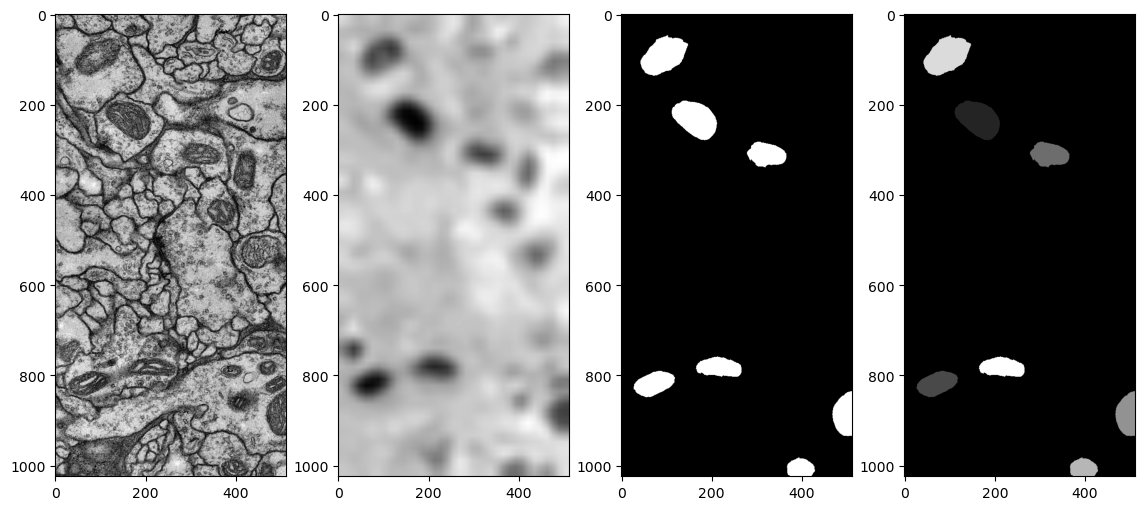

In [ ]:
threshold = 0.5

sam2_masks_binary = sam2_processor.refine_prediction_with_sam_masks(
    torch.from_numpy(predictions[0]).squeeze().to(device)
    )
sam2_masks_instance = sam2_processor.get_refined_instances_with_sam_prediction(
    torch.from_numpy(predictions[0]).squeeze().to(device),
    threshold=threshold
    )

plt.figure(figsize=(14,6))
plt.subplot(141)
plt.imshow(input_img[...,0], 'gray')
plt.title("Input image")
plt.subplot(142)
plt.imshow(predictions[0], 'gray')
plt.title("Predicted similarities")
plt.subplot(143)
plt.imshow(sam2_masks_binary < threshold, 'gray')
plt.title("Predicted segmentation (w/SAM2)")
plt.subplot(144)
plt.imshow(sam2_masks_instance, 'gray')
plt.title("Predicted instances (w/SAM2)")
plt.show()

### Post-Process and save all binary masks and instances

In [ ]:
import tifffile

dir_path = './dinoSim_sam2_results'

if dir_path and not os.path.exists(dir_path):
    os.makedirs(os.path.join(dir_path, "binary"), exist_ok=True)
    os.makedirs(os.path.join(dir_path, "instance"), exist_ok=True)

#process with SAM2 the dataset and save the results
for i in range(len(images)):
    sam2_processor.generate_sam_masks(images[i]) # time consuming!
    sam2_masks_binary = sam2_processor.refine_prediction_with_sam_masks(
        torch.from_numpy(predictions[i]).squeeze().to(device)
        )
    sam2_masks_instance = sam2_processor.get_refined_instances_with_sam_prediction(
        torch.from_numpy(predictions[i]).squeeze().to(device),
        threshold=threshold
        )

    tifffile.imwrite(os.path.join(dir_path, "binary", f'{i:04}_masks_binary.tif'), sam2_masks_binary)
    tifffile.imwrite(os.path.join(dir_path, "instance", f'{i:04}_masks_instance.tif'), sam2_masks_instance)
print("Done!")